# Dijkstra's algorithm

First, let's implement Dijkstra's algorithm, the simplest and most straightforward pathfinding algorithm.

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [406]:
map = np.zeros((15,15))
map[2:13,4:6] = 1
map[6:8,2:8] = 1
map[0:4,8:10] = 1
map[2:6,10:12] = 1

In [418]:
start, goal = (13,10), (1,10)

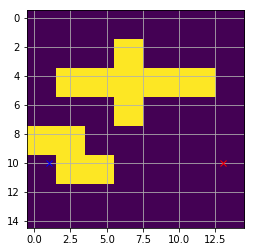

In [419]:
plt.imshow(map.T)
plt.plot(start[0], start[1], 'rx')
plt.plot(goal[0], goal[1], 'bx')
plt.grid()

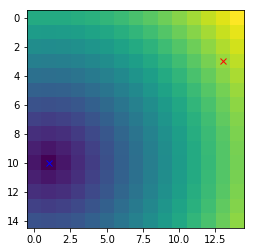

In [393]:
X, Y = np.meshgrid(np.arange(0,map.shape[0]) - goal[0], np.arange(0,map.shape[1]) - goal[1])
heuristic = (X ** 2 + Y ** 2) ** .5
plt.imshow(heuristic)
plt.plot(start[0], start[1], 'rx')
plt.plot(goal[0], goal[1], 'bx')

In [44]:
s = set([start, goal])
print(start, goal, s)
for n in s:
    print(n, start[0] + n[0], start[1] + n[1])

(1, 1) (8, 8) {(8, 8), (1, 1)}
(8, 8) 9 9
(1, 1) 2 2


In [364]:
neighbors = np.array([(-1,0), (0,-1), (1,0), (0,1)])

def dijkstra(map, start, goal):
    #map = map.T
    cost = np.infty * np.ones(map.shape)
    print('cost', cost.shape)
    open_set = set([start])
    cost[start] = 0
    count = 0
    evals = 0

    def build_path():
        current = goal
        path = []
        count = 0
        while start != current:
            next_nodes = np.array([(current[0] + n[0], current[1] + n[1]) for n in neighbors])
            prev_node = np.argmin(cost[next_nodes[:,0], next_nodes[:,1]])
            #print('goal: ', goal, next_nodes, ' prev: ', prev_node, next_nodes[prev_node])
            if 100 < count:
                break
            path.append(current)
            current = (next_nodes[prev_node][0], next_nodes[prev_node][1])
            count += 1
        path.append(start)
        path.reverse()
        print('evals: ', evals, ' path length:', len(path))
        return path

    while 0 < len(open_set):
        next_set = set()
        for node in open_set:
            for n in neighbors:
                next_node = (node[0] + n[0], node[1] + n[1])
                #print('next_node: ', next_node)
                if (0 <= next_node[0] and next_node[0] < cost.shape[0] and
                    0 <= next_node[1] and next_node[1] < cost.shape[1] and
                    map[next_node] == 0 and
                    cost[node] + 1 < cost[next_node]):
                    cost[next_node] = cost[node] + 1
                    next_set.add(next_node)
                    evals += 1
                    if next_node == goal:
                        return cost, build_path()
        open_set = next_set
        if 100 < count:
            break
        count += 1
    return cost, build_path()

In [420]:
cost, path = dijkstra(map, start, goal)
print(path)

cost (15, 15)
evals:  146  path length: 17
[(13, 10), (12, 10), (11, 10), (10, 10), (9, 10), (8, 10), (7, 10), (6, 10), (6, 11), (6, 12), (5, 12), (4, 12), (3, 12), (2, 12), (1, 12), (1, 11), (1, 10)]


Text(4,10,'Goal')

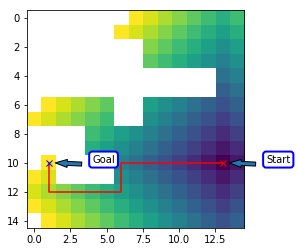

In [421]:
plt.imshow(cost.T)
plt.plot(np.array(path)[:,0], np.array(path)[:,1], 'r')
plt.plot(start[0], start[1], 'rx')
plt.plot(goal[0], goal[1], 'bx')
bbox = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2)
arrowprops = {'width': 4, 'shrink': .15, 'headwidth': 8}
plt.annotate('Start', start, start + np.array((3,0)), arrowprops = arrowprops, bbox = bbox)
plt.annotate('Goal', goal, goal + np.array((3,0)), arrowprops = arrowprops, bbox = bbox)

Wow, that's cool.

C:\Users\masah\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:1728: RuntimeWarning: invalid value encountered in subtract
  v1[which_pt] = np.array(ps2[i1]) - np.array(ps2[i2])
C:\Users\masah\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:1729: RuntimeWarning: invalid value encountered in subtract
  v2[which_pt] = np.array(ps2[i2]) - np.array(ps2[i3])
C:\Users\masah\Anaconda3\lib\site-packages\numpy\core\numeric.py:1765: RuntimeWarning: invalid value encountered in multiply
  multiply(a1, b2, out=cp0)
C:\Users\masah\Anaconda3\lib\site-packages\numpy\core\numeric.py:1770: RuntimeWarning: invalid value encountered in subtract
  cp1 -= tmp
C:\Users\masah\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:1784: RuntimeWarning: invalid value encountered in true_divide
  for n in normals])


C:\Users\masah\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:141: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


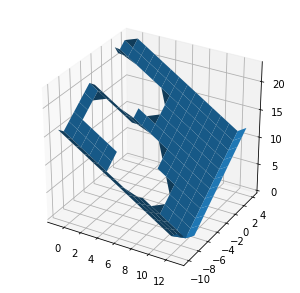

In [397]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, cost.T)

# A* algorithm

A* is an improved version of Dijkstra's algorithm which uses heuristic function to reduce iterations to find the path.

In a regular grid problem, we typically use Euclidian distance $h = \sqrt{x^2 + y^2}$ as heuristic function.

In [424]:
def heuristic_cost_estimate(start, goal):
    return 1*((start[0] - goal[0]) ** 2 + (start[1] - goal[1]) ** 2) ** .5

def reconstruct_path(cameFrom, current):
    total_path = [current]
    while current in cameFrom:
        current = cameFrom[current]
        total_path.append(current)
    return total_path

def A_Star(map, start, goal):
    """ A reference implementation from Wikipedia, ported from pseudocode to Python. 
    
    https://en.wikipedia.org/wiki/A*_search_algorithm
    
    It has advantage over Dijkstra's algorithm in that it tend to have fewer node evaluations,
    but it also requires closedSet separately from cost map.
    """
    # The set of nodes already evaluated
    closedSet = set()

    # The set of currently discovered nodes that are not evaluated yet.
    # Initially, only the start node is known.
    openSet = set([start])

    # For each node, which node it can most efficiently be reached from.
    # If a node can be reached from many nodes, cameFrom will eventually contain the
    # most efficient previous step.
    cameFrom = {}

    # For each node, the cost of getting from the start node to that node.
    gScore = np.infty * np.ones(map.shape)

    # The cost of going from start to start is zero.
    gScore[start] = 0

    # For each node, the total cost of getting from the start node to the goal
    # by passing by that node. That value is partly known, partly heuristic.
    fScore = np.infty * np.ones(map.shape)

    # For the first node, that value is completely heuristic.
    fScore[start] = heuristic_cost_estimate(start, goal)

    evals = 0
    open_history = []

    while len(openSet) != 0:
        open_history.append(len(openSet))
        openList = np.array([p for p in openSet])
        #print(openList)
        current = tuple(openList[fScore[openList[:,0], openList[:,1]].argmin()])
        #print(current)
        if current == goal:
            path = reconstruct_path(cameFrom, current)
            print('evals: ', evals, ' path length:', len(path))
            return path, gScore, open_history

        openSet.remove(current)
        closedSet.add(current)
        #print(closedSet)

        for n in neighbors:
            next_node = (current[0] + n[0], current[1] + n[1])

            if next_node in closedSet:
                continue # Ignore the neighbor which is already evaluated.

            #print('next_node: ', next_node)
            if (0 <= next_node[0] and next_node[0] < gScore.shape[0] and
                0 <= next_node[1] and next_node[1] < gScore.shape[1] and
                map[next_node] == 0 and
                gScore[current] + 1 < gScore[next_node]):

                # The distance from start to a neighbor
                tentative_gScore = gScore[current] + 1
                #print('tentative_gScore: ', tentative_gScore)

                evals += 1

                if next_node not in openSet: # Discover a new node
                    openSet.add(next_node)
                elif tentative_gScore >= gScore[next_node]:
                    continue

                # This path is the best until now. Record it!
                cameFrom[next_node] = current
                gScore[next_node] = tentative_gScore
                fScore[next_node] = gScore[next_node] + heuristic_cost_estimate(next_node, goal)
    return [], gScore, open_history

In [422]:
path, cost = A_Star(map, start, goal)
print(path)

evals:  95  path length: 17
[(1, 10), (1, 11), (1, 12), (2, 12), (3, 12), (4, 12), (5, 12), (6, 12), (6, 11), (6, 10), (7, 10), (8, 10), (9, 10), (10, 10), (11, 10), (12, 10), (13, 10)]


Text(4,10,'Goal')

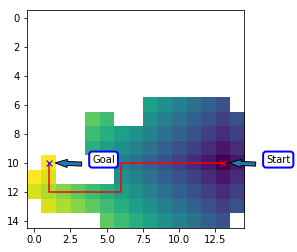

In [423]:
plt.imshow(cost.T)
plt.plot(np.array(path)[:,0], np.array(path)[:,1], 'r')
plt.plot(start[0], start[1], 'rx')
plt.plot(goal[0], goal[1], 'bx')
bbox = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2)
arrowprops = {'width': 4, 'shrink': .15, 'headwidth': 8}
plt.annotate('Start', start, start + np.array((3,0)), arrowprops = arrowprops, bbox = bbox)
plt.annotate('Goal', goal, goal + np.array((3,0)), arrowprops = arrowprops, bbox = bbox)